In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

from sklearn import tree
import pandas as pd

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory


# import os
# os.environ["PATH"] += os.pathsep + r'C:\Users\Egor\AppData\Local\Programs\Python\Python39\Lib\site-packages\graphviz'

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# Импортируем код для визулизации дерева решений

from IPython.display import SVG
from graphviz import Source
from IPython.display import display

from IPython.display import HTML
# style = "<style>svg{width:50% !important;height:50% !important;}</style>"
# HTML(style)

In [3]:
# Импортируем данные из соревнования, сохраняя путь к файлам в переменной DATA_DIR
DATA_DIR = 'data/'
train = pd.read_csv(DATA_DIR + 'train.csv')
train.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,Id
0,1,85,66,29,0,26.6,0.351,31,0,1
1,8,183,64,0,0,23.3,0.672,32,1,2
2,1,89,66,23,94,28.1,0.167,21,0,3
3,0,137,40,35,168,43.1,2.288,33,1,4
4,5,116,74,0,0,25.6,0.201,30,0,5


In [4]:
X = train.drop(['Outcome'], axis=1)
y = train.Outcome

In [5]:
clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=6)

In [6]:
clf.fit(X, y)

DecisionTreeClassifier(criterion='entropy', max_depth=6)

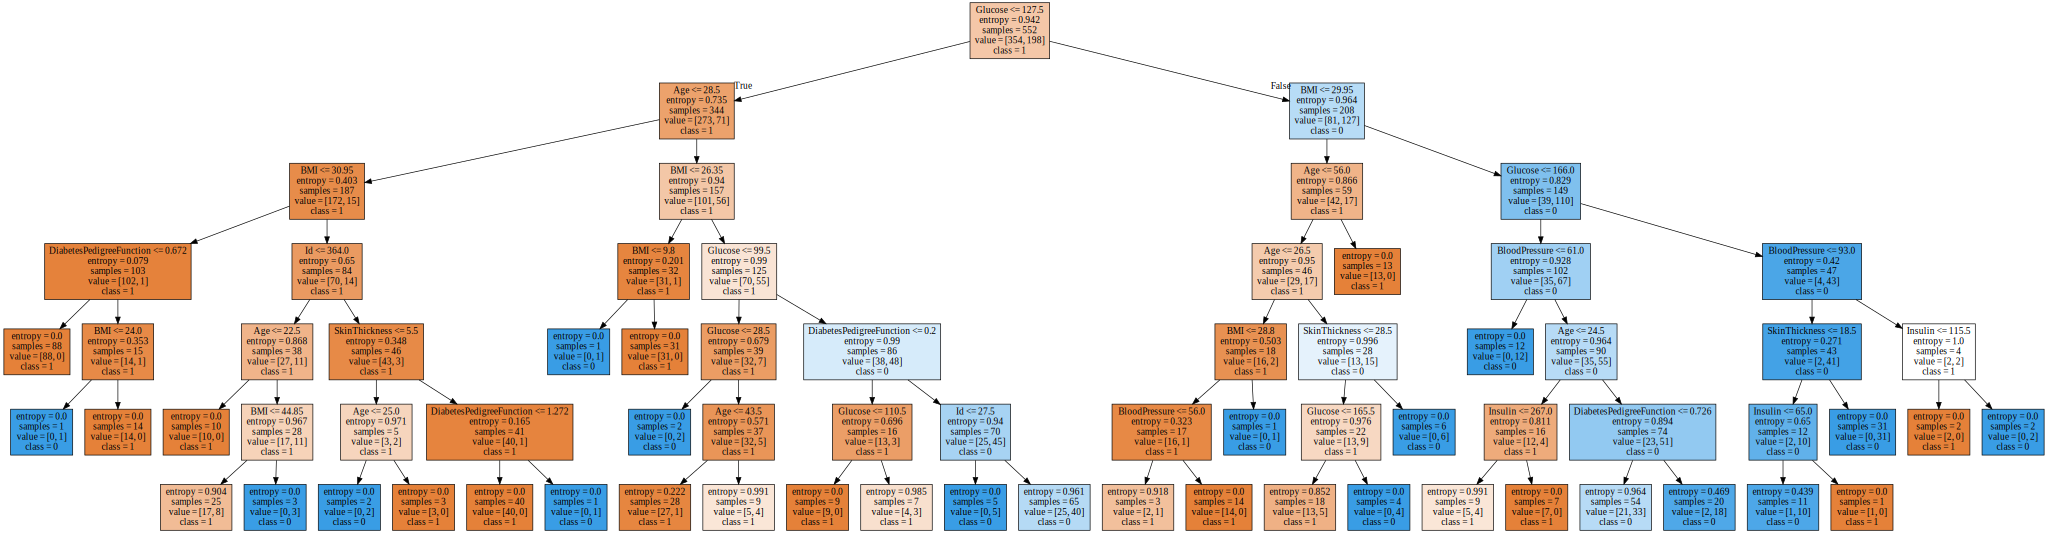

In [7]:
graph = Source(tree.export_graphviz(clf, out_file=None,
                                   feature_names=list(X),
                                   class_names=['1','0'],
                                   filled = True))
display(SVG(graph.pipe(format='svg')))

In [8]:
test = pd.read_csv(DATA_DIR + 'test.csv')
test.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Id
0,6,148,72,35,0,33.6,0.627,50,0
1,8,125,96,0,0,0.0,0.232,54,9
2,10,168,74,0,0,38.0,0.537,34,11
3,10,139,80,0,0,27.1,1.441,57,12
4,5,166,72,19,175,25.8,0.587,51,14


In [9]:
submission = clf.predict(test)

In [10]:
submission

array([1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1,
       0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1,
       1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0,
       1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0], dtype=int64)

In [11]:
sample_submission = pd.read_csv(DATA_DIR + 'sample_submission.csv')
sample_submission.head()

,Id,Outcome
0,0,1
1,9,1
2,11,1
3,12,1
4,14,1


In [12]:
# Сохраняем предсказания в отдельный файл, он будет доступен для скачивания справа 
sample_submission['Outcome'] = submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,Id,Outcome
0,0,1
1,9,1
2,11,1
3,12,0
4,14,1
5,17,1
6,20,0
7,22,1
8,24,1
9,26,1
